# The 2D Ising Model 


This is the IPython notebook compiled by me, Blaise Delaney (Junior Sophister Theoretical Physics, ID: 12313570), to tackle the tasks set by Dr. Thomas Archer for the course PY3C01, Trinity College, University of Dublin.

Firstly, we need to create a code cell to enable all the relevant imports. This shall be updated progressively to tacl the different sections of the problem set.

In [42]:
from __future__ import division #necessary to perform division of ints effectively cast into floats before division

import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rand

#ipython, plot in notebook
%matplotlib inline 

Now, onto the random spin configuration. This can be up or down, so we shall select a grid with the following conditions: 

- spin up $\uparrow$ $=1$
- spin down $\downarrow$ $=-1$




It is probably a good idea to take a object-oriented approach. Define a class <span style="color: crimson"> Ising() </span>.

In [43]:
#Global parameters

N = 16 #grid dimensions
J = 1.0 #coupling in the hamiltonian

The Hamiltonian is 

$$H = -J  \sum_{<i,j>}  S_i \cdot S_j - h \sum_i S_i$$

We want to investihate the behaviour of a <span style="color: crimson"> ferromagnet </span>. That is, for $J > 0$, we expect an orderly spin lattice arrangement, disrupted for temperatures equal or greater than $T_c$, the Curie temperature. In this regime, we expect paramagnetism.

Energy computations: the energy (Hamiltonian, isolated system) at of a spin site $(h = 0)$ is given by eq. (1)

$$ H_{i,j} = - J S_{i,j} \cdot (\sum_{nn} S)$$    

the Hamiltonian associated with the spin-flipped state (single spin flip dynamics are assumed to allow for a transition from a state in to another) is simple eq. (2)

$$H_{i,j} =  J S_{i,j} \cdot (\sum_{nn} S) $$

Thus, given that $\Delta E = (2) - (1)$

$$\Rightarrow \Delta E = 2 J S_{i,j}\cdot(\sum_{nn} S)$$

where is $\Delta E < 0$, flipping the spin lowers the energy of the system. Metropolis-Hastings can be then applied.


In [44]:
#2d Ising model basic class
class Ising():
    
    #random spin configuration, grid of spins
    def spin_config(self):
        #X,Y the grid dimensions
        lattice = np.zeros((N,N), dtype = int) #precaution, set integer grid of zeros
        for i in range(N): 
            for j in range(N):
                lattice[i, j] = np.sign(2*rand.rand() - 1)
        return lattice
    
    #plot the spin configuration in the lattice 
    def lattice_plt(self):
        plt.matshow(lattice, cmap=plt.cm.gray)
        #  #LaTeX
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')

        plt.title("Spin configuration in the lattice")
        plt.axis('off')
        plt.show()
        
    #delta_energy with periodic BC imposed using the modulo operator, per spin site
    def dEnergy(self, lattice,i,j): 
        return 2*J *lattice[i][j]*(lattice[(i+1) % N][j] + lattice[(i-1) % N][j] 
                          + lattice[i][(j+1) % N] +  lattice[i][(j-1) % N])
    
    #for comparison, not sweeping the lattice, but random sampling metripolis
    def metropolis_random(self, lattice, kT):
        for i in range(N):
            for j in range(N):
                #random sampling
                x = np.random.randint(0, N)
                y = np.random.randint(0, N)
                site = lattice[x][y]
                nb = lattice[(i+1) % N][j] + lattice[(i-1) % N][j]+ lattice[i][(j+1) % N] +  lattice[i][(j-1) % N]
                dErg = 2*site*nb
                if dErg < 0:
                    site *= -1
                elif np.exp(-dErg/kT) > rand.rand():
                    site *= -1 #accept according to Boltzmann dist.
                lattice[i][j] = site
        return lattice
    
    #metropolis with periodic BC
    def metropolis(self, lattice, kT):
        for i in range(N):
            for j in range(N):
                delta_E = self.dEnergy(lattice,i ,j)
                site = lattice[i][j]
                if delta_E<0:
                    site *= -1 #energy is lowered, accept
                elif np.exp(-delta_E/kT) > rand.rand(): #COMMMENT ON RAND(); uniform distribution in [0,1)
                    site *= -1 #accept according to Boltzmann dist.
                lattice[i][j] = site
        return lattice
    
    #magnetization 
    def magnetization(self, lattice):
        magnt = np.sum(lattice) #add all spins
        return magnt
    
    #energy
    def energy(self, lattice):
        erg = 0
        for i in range(N):
            for j in range(N):
                #sum of neighbouring spins
                sum_nb = lattice[(i+1) % N][j] + lattice[(i-1) % N][j] + lattice[i][(j+1) % N] +  lattice[i][(j-1) % N]
                #energy per site (not normalised)
                erg += -lattice[i][j]*sum_nb
        norm_energy = erg/2.0 #divide by twice number of spins to avoid overcounting
        return norm_energy


In [45]:
model = Ising() #constructor

Now run the main simulation using the class Ising( ). Allow for the system to achieve equilibrium after a given relaxation time then collect the statistics. The physical observables are obtained normalising dividing by the iterations to collect the statistics and by the total spin sites. 

Focus on the following:

- magnetization per site (absolute value)   $|<M>|$
- energy per site $E_{site}$
- susceptibility $\chi$
- heat capacity at constant volume $C_V$

In [46]:
steps = 2000 #steps for equilibrium
temp_steps = 128 #step size for increase in temperature [J/k]

kT = np.linspace(1.0,4.0,temp_steps) #temperature values

#arrays for future plotting
magnetization = np.zeros(temp_steps) 
Energy = np.zeros(temp_steps)
susceptibility = np.zeros(temp_steps)
specific_heat = np.zeros(temp_steps)

for l in range(len(kT)):
    temperature = kT[l]
    
    #initialise observables to zero
    M = 0
    E = 0
    M_sq = 0
    E_sq = 0
    
    #reset to random initial configuration
    lattice = model.spin_config()  
    
    #set out to reach equilibrium
    for t in range(steps):
        model.metropolis(lattice, temperature)
        
    #collect statistics
    stat_steps = int(steps/2) 
    for k in range(stat_steps):  
        
    #######################################
    #comment on why apply metropolis again#   #is this is effectively the same as evolving the system for the previous equilibrium
    #######################################
    
        model.metropolis(lattice, temperature) 
        mag = model.magnetization(lattice) 
        engy = model.energy(lattice)
        
        #add contribution to observables
        M = M + mag
        E = E + engy
        M_sq = M_sq + mag*mag
        E_sq = E_sq + engy*engy
        
        #arrays of observables, after equilibrium is achieved
        magnetization[l] = abs(M)/(stat_steps*N*N) 
        Energy[l] = E/(stat_steps*N*N) 
        susceptibility[l] = ( (M_sq/stat_steps) - ((M*M)/(stat_steps**2)) )/(N*kT[l]*kT[l])
        specific_heat[l] = ( (E_sq/stat_steps) - ((E*E)/(stat_steps**2)) )/(N*kT[l]*kT[l])
        
        
#######################################
#check for proper calculations of C, X#
#######################################

Plot the dependence of the physical observables as a function of temperature $[\frac{J}{k_B}]$

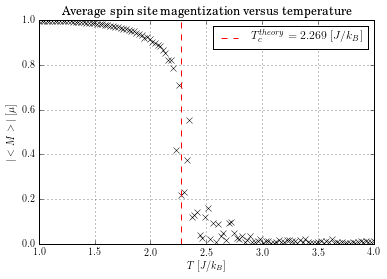

In [47]:
plt.figure()
plt.plot(kT, magnetization, 'kx')

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.title("Average spin site magentization versus temperature")
plt.xlabel("$T$ $[J/k_B]$")
plt.ylabel("$|<M>|$ $[\mu]$")

#see if theory matches results (Onsager, 1944)
plt.axvline(2.269, color ='r',linestyle='dashed', label="$T_c^{theory} = 2.269$ $[J/k_B]$")
plt.legend()

plt.grid()
plt.savefig('av_mag_rand.eps')

plt.show()


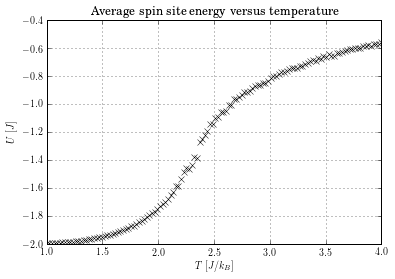

In [48]:
plt.figure()
plt.plot(kT, Energy, 'kx')

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.title("Average spin site energy versus temperature")
plt.xlabel("$T$ $[J/k_B]$")
plt.ylabel("$U$ $[J]$")
plt.grid()
plt.savefig('av_erg_black_try.eps')

plt.show()

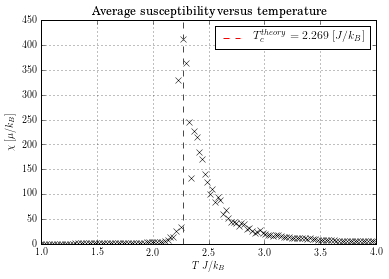

In [49]:
plt.figure()
plt.plot(kT, susceptibility, 'kx')

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.title("Average susceptibility versus temperature")
plt.xlabel("$T$ $J/k_B$")
plt.ylabel("$\chi$ $[\mu/ k_B]$")

#see if theory matches results (Onsager, 1944)
plt.axvline(2.269, color ='r',linestyle='dashed', label="$T_c^{theory} = 2.269$ $[J/k_B]$")
plt.legend()

plt.grid()
plt.savefig('av_suscpt.eps')

plt.show()

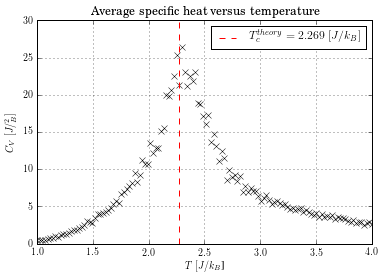

In [50]:
plt.figure()
plt.plot(kT, specific_heat, 'kx')

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.title("Average specific heat versus temperature")
plt.xlabel("$T$ $[J/k_B$]")
plt.ylabel("$C_V$ $[J/_B^2]$")

#see if theory matches results (Onsager, 1944)
plt.axvline(2.269, color ='r',linestyle='dashed', label="$T_c^{theory} = 2.269$ $[J/k_B]$")
plt.legend()

plt.grid()
plt.savefig('av_C.eps')

plt.show()

Initial random spin configuration


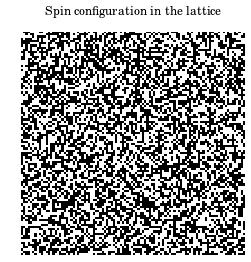

Temperature = 0.300000


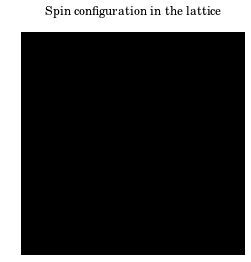

Temperature = 1.000000


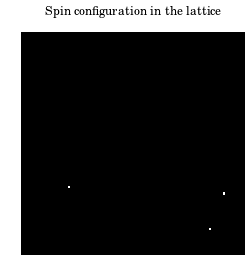

Temperature = 1.500000


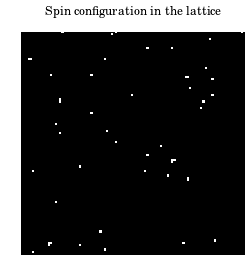

Temperature = 2.269000


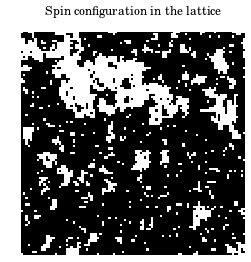

Temperature = 3.000000


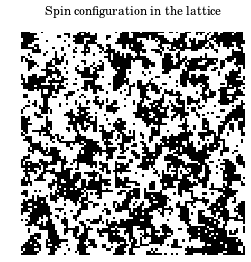

Temperature = 3.500000


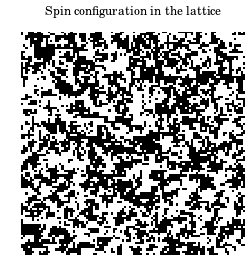

Temperature = 4.000000


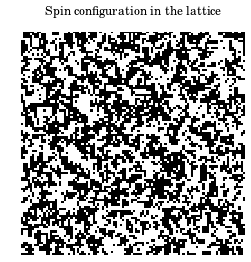

In [18]:
#show change of regime 


N = 100
T = [0.3,1.0, 1.5, 2.269,3.0, 3.5, 4]  #showcase para/ferro-magnetic spin configuration


print "Initial random spin configuration"
lattice = model.spin_config()
model.lattice_plt()
for t in T:
    
    #lattice = model.spin_config()
    for q in range(1001):
        
        model.metropolis(lattice, t)
        
        if q == 1000:
            print "Temperature = %f" %t
            model.lattice_plt()
            
        
        
        